## Other potential BHO packages in Python

* hyperopt
* optuna
* hpbandster
* BayesianOptimization
* Sherpa
* SMAC3

In [1]:
import warnings
import pprint
import logging
from collections import namedtuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import roc_auc_score

import lightgbm as lgb
import skopt
import skopt.plots

%matplotlib inline

logging.getLogger("lightgbm").setLevel(logging.DEBUG)   # turn off lightgbm messages

In [2]:
# load data
X, y = load_breast_cancer(return_X_y=True)

# # convert y to binary (predict 2 as the positive target)
# y = np.where(y == 1, 0, y)
# y = np.where(y == 2, 1, y)

In [3]:
# split data for early stopping demonstration
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=17,
    stratify=y,
)

In [4]:
# create param space
STATIC_PARAMS = {
    "boosting_type": "goss",
    "objective": "binary",
    "random_state": 13,
    "subsample_freq": 1,
    "metric": ["auc", "binary_logloss"],
    "first_metric_only": True,
    "num_boost_round": 200,
    "early_stopping_rounds": 10,
    "verbose": -1,   # turns off lgb logging messages durng BHO
    "n_jobs": None,
}

PARAM_SPACE = [
    skopt.space.Integer(2, 16, name="num_leaves"),
    skopt.space.Integer(1, 5, name="max_depth"),
    skopt.space.Real(0.0001, 0.1, name="learning_rate", prior="log-uniform"),
    skopt.space.Real(0.1, 1.0, name="colsample_bytree"),
    skopt.space.Integer(1, 20, name="min_child_weight"),
    skopt.space.Categorical([True, False], name="extra_trees")
]

param_sampler = skopt.Space(PARAM_SPACE)
param_sampler.param_names = [param.name for param in PARAM_SPACE]   # for convenience

In [5]:
# if I wanted to random search myself...
sample = param_sampler.rvs(1)
pprint.pprint(dict(zip(param_sampler.param_names, sample[0])))

{'colsample_bytree': 0.8251999284136782,
 'extra_trees': False,
 'learning_rate': 0.000651401282081048,
 'max_depth': 4,
 'min_child_weight': 7,
 'num_leaves': 12}


In [6]:
# setup objective function
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

def train_evaluate(params):
    results_dict = dict()
    model = lgb.train(
        params,
        train_data,
        valid_sets=test_data,
        evals_result=results_dict,
        verbose_eval=False,
    )
    return results_dict["valid_0"]["auc"][-1]

@skopt.utils.use_named_args(PARAM_SPACE)
def objective(**params):
    all_params = {**params, **STATIC_PARAMS}
    return -train_evaluate(all_params)

In [7]:
# round 1 bayes search
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    results = skopt.forest_minimize(
        objective,
        PARAM_SPACE,
        n_calls=20,
        n_points=10000,
        n_random_starts=10,
        random_state=13,
        acq_func="LCB",
        kappa=3.0,
        verbose=True,
    )

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0212
Function value obtained: -0.9720
Current minimum: -0.9720
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0126
Function value obtained: -0.9761
Current minimum: -0.9761
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0085
Function value obtained: -0.9702
Current minimum: -0.9761
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0111
Function value obtained: -0.9787
Current minimum: -0.9787
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0134
Function value obtained: -0.9801
Current minimum: -0.9801
Iteration No: 6 started. 

In [8]:
print(type(results), end="\n\n")
print(results.keys())

<class 'scipy.optimize._optimize.OptimizeResult'>

dict_keys(['x', 'fun', 'func_vals', 'x_iters', 'models', 'space', 'random_state', 'specs'])


In [9]:
# round 2 search
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    results = skopt.forest_minimize(
        objective,
        PARAM_SPACE,
        n_calls=10,
        n_points=10000,
        n_random_starts=0,
        random_state=19,
        acq_func="LCB",
        kappa=1.96,
        x0=results["x_iters"],      # pass results from previous round
        y0=results["func_vals"],    # pass results from previous round
        verbose=True,
    )

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.2990
Function value obtained: -0.9870
Current minimum: -0.9902
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.3807
Function value obtained: -0.9880
Current minimum: -0.9902
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.3921
Function value obtained: -0.9847
Current minimum: -0.9902
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.4460
Function value obtained: -0.9860
Current minimum: -0.9902
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.4515
Function value obtained: -0.9892
Current minimum: -0.9902
Iteration No: 6 started. 

In [10]:
# round 3 search
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    results = skopt.forest_minimize(
        objective,
        PARAM_SPACE,
        n_calls=10,
        n_points=10000,
        n_random_starts=0,
        random_state=23,
        acq_func="LCB",
        kappa=1.96,
        x0=results["x_iters"],      # pass results from previous round
        y0=results["func_vals"],    # pass results from previous round
        verbose=True,
    )

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.3159
Function value obtained: -0.9888
Current minimum: -0.9905
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.4948
Function value obtained: -0.9822
Current minimum: -0.9905
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.4207
Function value obtained: -0.9867
Current minimum: -0.9905
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.4140
Function value obtained: -0.9909
Current minimum: -0.9909
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.5318
Function value obtained: -0.9908
Current minimum: -0.9909
Iteration No: 6 started. 

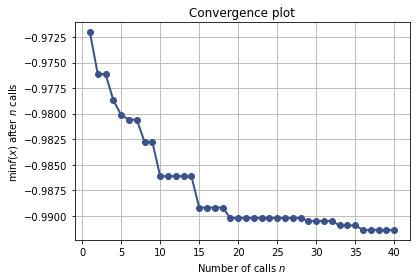

In [11]:
# plot the results
skopt.plots.plot_convergence(results);

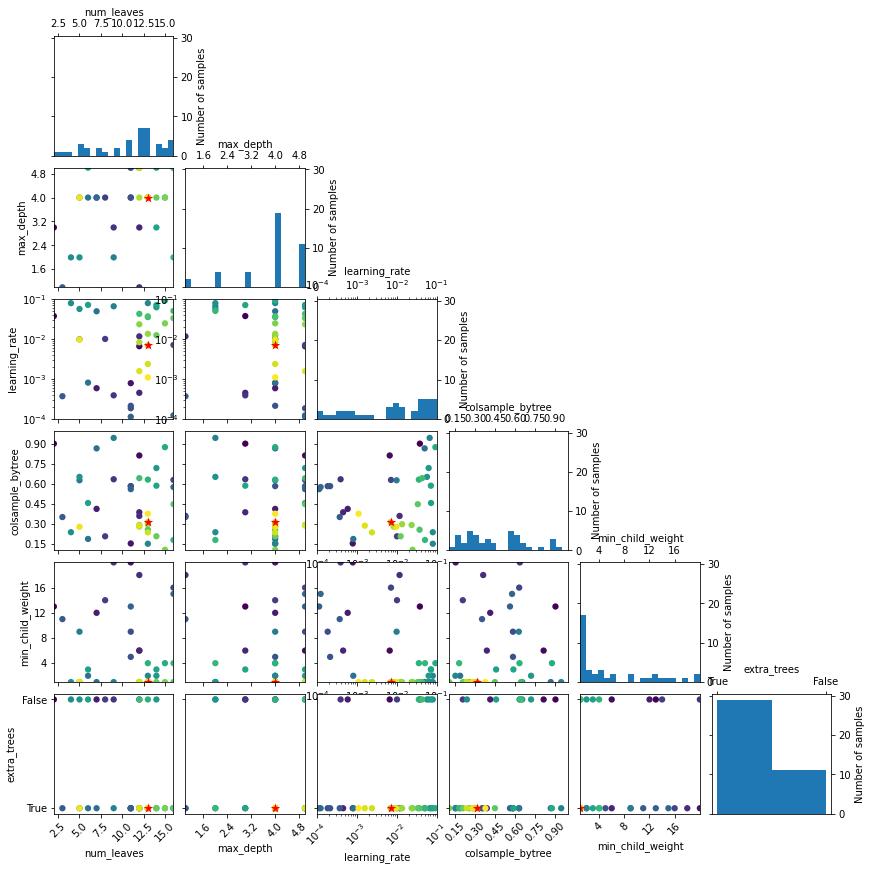

In [12]:
skopt.plots.plot_evaluations(results);

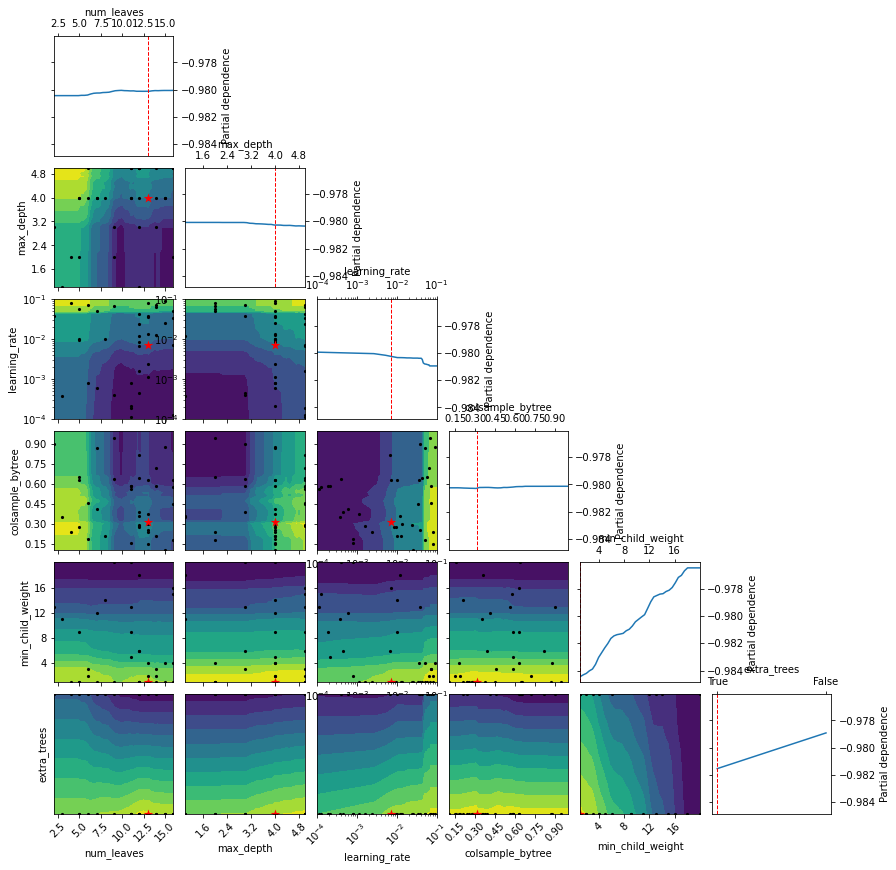

In [13]:
skopt.plots.plot_objective(results);

In [14]:
# fit a final model
print("Best objective function: {:.3f}".format(results["fun"]))
print()
print(pprint.pprint(dict(zip(param_sampler.param_names, results["x"]))))

Best objective function: -0.991

{'colsample_bytree': 0.3132144788125406,
 'extra_trees': True,
 'learning_rate': 0.006987474020380846,
 'max_depth': 4,
 'min_child_weight': 1,
 'num_leaves': 13}
None


In [15]:
pprint.pprint(results)

{'fun': -0.9913843457943925,
 'func_vals': array([-0.97203563, -0.97612442, -0.97021028, -0.97867991, -0.98014019,
       -0.98057827, -0.97269276, -0.98276869, -0.97765771, -0.98612734,
       -0.98393692, -0.9807243 , -0.98028621, -0.97999416, -0.98919393,
       -0.98116238, -0.98276869, -0.9833528 , -0.99021612, -0.9870035 ,
       -0.9880257 , -0.98466706, -0.98598131, -0.98919393, -0.98685748,
       -0.97714661, -0.98525117, -0.97743867, -0.99050818, -0.98875584,
       -0.98218458, -0.98671145, -0.99094626, -0.99080023, -0.99050818,
       -0.99138435, -0.98846379, -0.98831776, -0.98656542, -0.98452103]),
 'models': [ExtraTreesRegressor(min_samples_leaf=3, n_estimators=100, random_state=74293843),
            ExtraTreesRegressor(min_samples_leaf=3, n_estimators=100, random_state=74293843),
            ExtraTreesRegressor(min_samples_leaf=3, n_estimators=100, random_state=74293843),
            ExtraTreesRegressor(min_samples_leaf=3, n_estimators=100, random_state=74293843),
   